# Metastatic tissue identifier with Convolutional Neural Networks:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import visualkeras
import tensorflow as tf
print("DONE IMPORTING!")

DONE IMPORTING!


Printing the files available in the main directory so as to know the distribution of images.

In [2]:
os.listdir('input')

['sample_submission.csv', 'test', 'train', 'train_labels.csv']

Printing the file name of the first five images in the training dataset:

In [6]:
os.listdir('input/train')[:5]

['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif',
 '000020de2aa6193f4c160e398a8edea95b1da598.tif',
 '00004aab08381d25d315384d646f5ce413ea24b1.tif',
 '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif',
 '0000da768d06b879e5754c43e2298ce48726f722.tif']

Number of images in each folder.

In [7]:
len(os.listdir('input/train'))

220026

In [8]:
len(os.listdir('input/test'))

57458

In [9]:
df=pd.read_csv('input/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Plotting the distribution of categories as proportions just to know if the data is balanced or not.

In [10]:
df.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

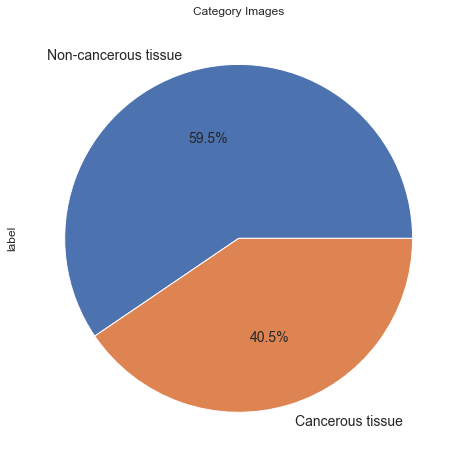

In [11]:
sns.set(style='whitegrid')
pie_chart=pd.DataFrame(df['label'].replace(0,'Non-cancerous tissue').replace(1,'Cancerous tissue').value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Category Images',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(18,8))

In [12]:
from PIL import Image

151577    1
Name: label, dtype: int64


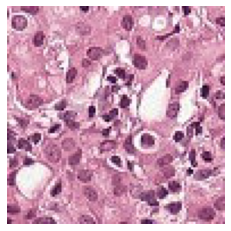

In [22]:
im = Image.open('input/train/'+os.listdir('input/train')[0])
plt.imshow(im)
plt.axis('off')
print(df[df.id==os.listdir('input/train')[0].split('.')[0]].label)

In [23]:
Labels = df.label.values
Labels

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [24]:
def get_indexes(label,list_n):
  for x in range(len(Labels)):
    if Labels[x]==label:
      list_n.append(x)
  return list_n

In [25]:
no_cancer=[]
no_cancer=get_indexes(0,no_cancer)
cancer=[]
cancer=get_indexes(1,cancer)

In [26]:
def get_classlabel(class_code):
    labels = {0:'Non-cancerous', 1:'Cancerous'}
    
    return labels[class_code]

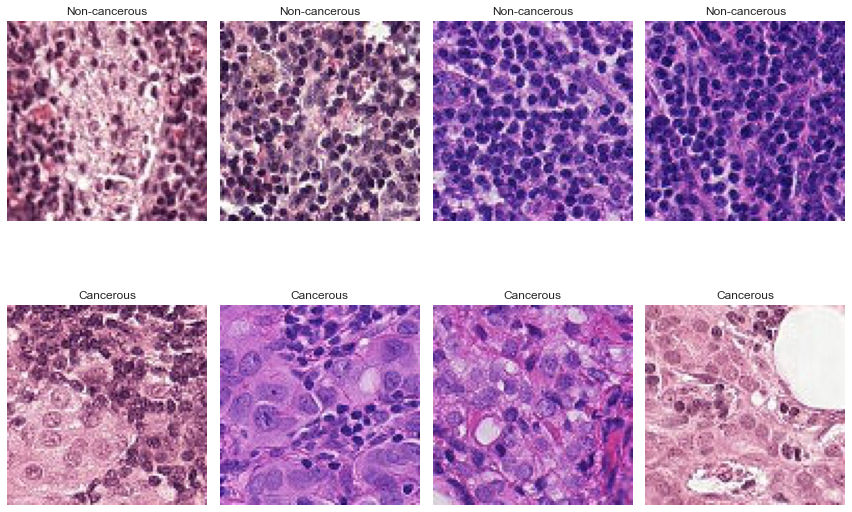

In [29]:
import random
from random import randint

f,ax = plt.subplots(2,4, figsize=(12,12)) 
types_img=[no_cancer, cancer]

for z in range(0,2,1):
    for j in range(0,4,1):
        rnd_number=random.choice(types_img[z])
        ax[z,j].imshow(Image.open('input/train/'+df.iloc[rnd_number,0]+'.tif'))
        ax[z,j].set_title(get_classlabel(z))
        ax[z,j].axis('off')
        plt.tight_layout()

Getting rid of the next images as they either create errors during training or doesn't represent its category:

Text(0.5, 1.0, 'Black Image')

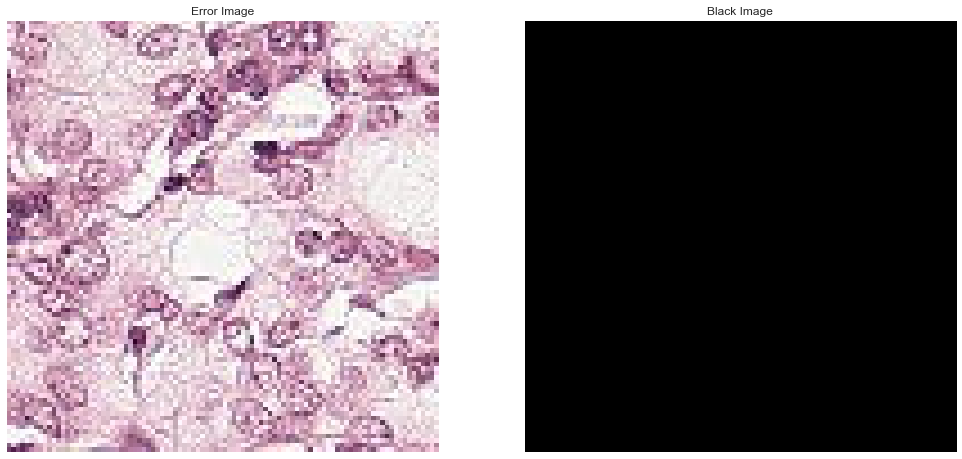

In [30]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(17,17))

ax1.imshow(Image.open('input/train/'+'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif'))
ax1.axis('off')
ax1.set_title('Error Image')

ax2.imshow(Image.open('input/train/'+'9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif'))
ax2.axis('off')
ax2.set_title('Black Image')

In [31]:
df.shape

(220025, 2)

In [32]:
# removing this image because it caused a training error previously
df = df[df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df = df[df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df.shape)

(220023, 2)


Creating dataframes containing the id's of each category and gather 89000 images:

In [34]:
SAMPLE_SIZE=89000

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 42)
# filter out class 1
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 42)

Concatenating them so as to have one file containing 178000 images, finally we will shuffle it because it was sorted:

In [35]:
from sklearn.utils import shuffle

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    89000
0    89000
Name: label, dtype: int64

In [36]:
df_data.head(10)

,id,label
30828,a167f8dd10e654cf23ac17811aa74c2a6bc9c593,0
39481,0f8b3af6a1a93d486f247e0687a126f75aa87f1a,0
13887,2b533901c170103d1bd9bf18a166eee7c055e285,0
84138,27662a8f01c03a75b2e93b65e19dd4d6ba5c0c6c,0
23326,c19c38032f069055f4445d4ead6185180be70b55,0
90910,c58c61dfea53677226d84062386d5c62208dd3b7,1
21544,bd2f7d0f46934fbabb72488f37e226947d2814db,0
82269,709065ad906824a0191978db8a4246db65e3eaf6,0
35375,98b1dfe94e9694e06db8e309c8527308cc54a846,0
39783,91101fb0f49556f68d3ad97ec74404a628e7ef0b,0


Now that we have a balanced dataset we can split into training and validation sets at 10% as a typical ML workflow.

In [37]:
# train_test_split
from sklearn.model_selection import train_test_split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=42, stratify=y)

print(df_train.shape)
print(df_val.shape)

(160200, 2)
(17800, 2)


In [38]:
df_train['label'].value_counts()

1    80100
0    80100
Name: label, dtype: int64

In [39]:
df_val['label'].value_counts()

1    8900
0    8900
Name: label, dtype: int64

In [40]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# Inside each folder we create separate folders for each class

# create new folders inside train_dir
non_cancerous_tissue = os.path.join(train_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(train_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)

# create new folders inside val_dir
non_cancerous_tissue = os.path.join(val_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(val_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)

We have to set the 'id' column as index in order to gather the image labels more easily, this will help us when copying the images to our just created directories:

In [41]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [42]:
df_data.head()

,label
id,
a167f8dd10e654cf23ac17811aa74c2a6bc9c593,0
0f8b3af6a1a93d486f247e0687a126f75aa87f1a,0
2b533901c170103d1bd9bf18a166eee7c055e285,0
27662a8f01c03a75b2e93b65e19dd4d6ba5c0c6c,0
c19c38032f069055f4445d4ead6185180be70b55,0


Copying the images to their respective directories:

In [43]:
import shutil

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

# Transfer the train images
for image in train_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'non_cancerous_tissue'
    if target == 1:
        label = 'cancerous_tissue'
    
    # source path to image
    src = os.path.join('input/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images
for image in val_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'non_cancerous_tissue'
    if target == 1:
        label = 'cancerous_tissue'
    
    # source path to image
    src = os.path.join('input/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [44]:
# check how many training images we have in each folder
print(len(os.listdir('base_dir/train_dir/non_cancerous_tissue')))
print(len(os.listdir('base_dir/train_dir/cancerous_tissue')))

80100
80100


In [45]:
# check how many validation images we have in each folder
print(len(os.listdir('base_dir/val_dir/non_cancerous_tissue')))
print(len(os.listdir('base_dir/val_dir/cancerous_tissue')))

8900
8900


In [46]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

ImageDataGenerator to augment our data.

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE=96
datagen = ImageDataGenerator(rescale=1.0/255,
                             featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = datagen.flow_from_directory(valid_path,
                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                      batch_size=val_batch_size,
                                      class_mode='binary',
                                      shuffle=True)

# Note: shuffle=False causes the test dataset to not be shuffled
val2_gen = datagen.flow_from_directory(valid_path,
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       batch_size=1,
                                       class_mode='binary',
                                       shuffle=False)

Found 160200 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.


## Modeling:

In [48]:
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Reshape, LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta

Defining three callbacks that will help us to improve the training, stop it once it reaches a threshold and save the best model according to its accuracy:

In [49]:
#Will stop the training once it reaches 99% validation accuracy:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
        
callbacks = myCallback()

#Will reduce the learning rate is validation accuracy didn't improve in one epoch:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=1, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.000001)

#Will save the very best model according to validation accuracy:
from tensorflow.keras.callbacks import ModelCheckpoint
model_dir = 'CNN_model_histo.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

CNN with 4 sets of layers including 2D-Convolutional, 2D-Max Pooling and Batch Normalization, at the end we add a couple of Dropout and Dense layers.

In [50]:
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model=Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                        

Yelow: Conv2D, Red: MaxPooling, Green: BatchNormalization, Blue:Flatten, Black: Dropout, Yelow: Dense.

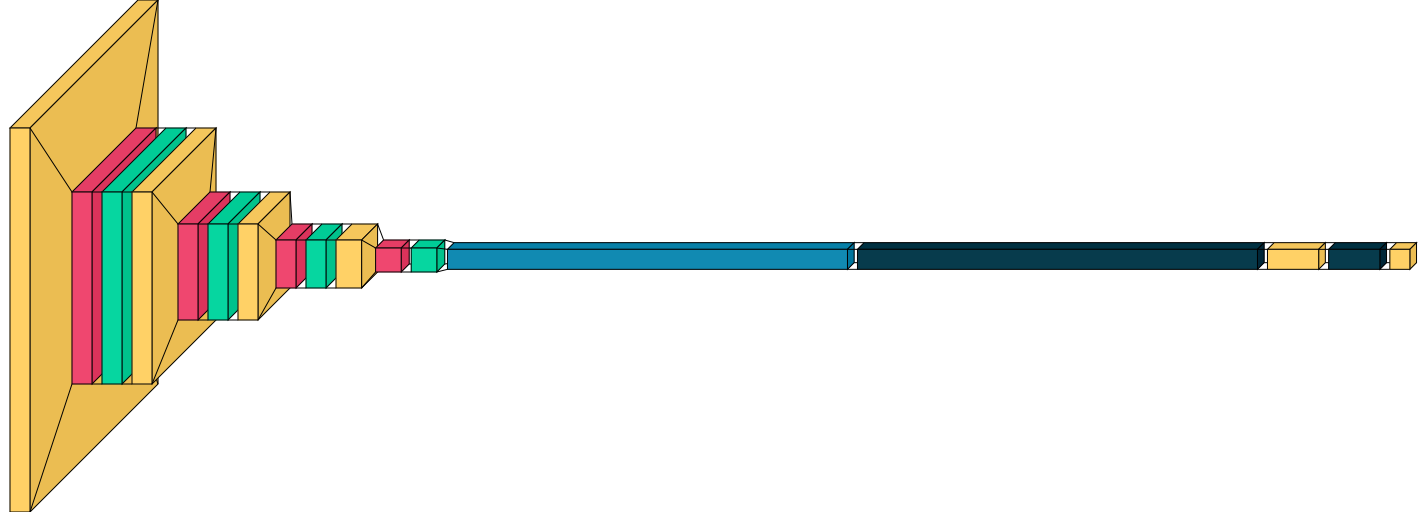

In [43]:
#visualkeras.layered_view(model)

Training for 20 epochs.

In [ ]:
history = model.fit(train_gen, validation_data=val_gen,
                              epochs=20, verbose=1,
                              callbacks=[callbacks, lr_reduction, checkpoint])

Epoch 1/20
5007/5007 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8340
Epoch 00001: val_accuracy improved from -inf to 0.86399, saving model to CNN_model_histo.h5
5007/5007 [==============================] - 4461s 890ms/step - loss: 0.4018 - accuracy: 0.8340 - val_loss: 0.3248 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 2/20
3911/5007 [======================>.......] - ETA: 17:04 - loss: 0.2943 - accuracy: 0.8809

The best model reached 95.37% validation accuracy and was saved in the CNN_model_histo.h5 file.

In [47]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.395796,0.834601,0.651430,0.709719,0.001000
1,0.289166,0.883989,0.734206,0.801685,0.001000
2,0.250790,0.902615,0.709318,0.731517,0.001000
3,0.206444,0.921067,0.229809,0.905449,0.000500
4,0.192805,0.926517,0.297076,0.893764,0.000500
5,0.170713,0.936086,0.168331,0.933708,0.000250
6,0.166515,0.938352,0.178754,0.930786,0.000250
7,0.155680,0.942335,0.161000,0.939101,0.000125
8,0.152848,0.942871,0.146189,0.945056,0.000125
9,0.150081,0.944744,0.162428,0.937472,0.000125


In [86]:
def metrics_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1,1)

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

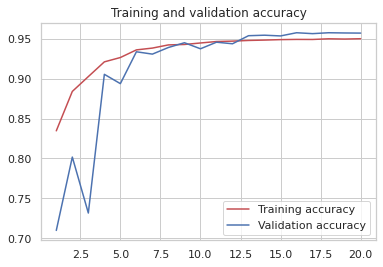

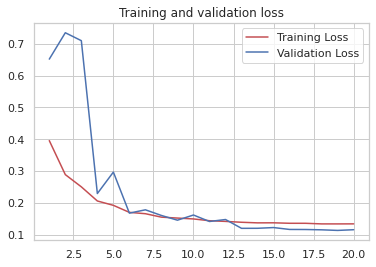

In [49]:
metrics_plot(history)

We can see the validation set had a performance which was underdamped and the settling time was equivalent to around 15 epochs, this is the main why we trained for 20 epochs and used ModelCheckpoint.

In [62]:
from keras.models import load_model

model_saved = load_model('./CNN_model_histo.h5')

2022-04-22 17:46:38.887611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 17:46:38.981926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 17:46:38.982056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 17:46:38.984029: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
202

In [74]:
model_saved.save('CNN_model_histo.h5')

In [75]:
model_saved.evaluate(val2_gen, steps=len(df_val), verbose=1)

17800/17800 [==============================] - 32s 2ms/step - loss: 0.1162 - accuracy: 0.9569


[0.11618280410766602, 0.9569101333618164]

In [52]:
predicted_val_prob = model_saved.predict(val2_gen, steps=len(df_val), verbose=1)

17800/17800 [==============================] - 32s 2ms/step


In [53]:
Y_val_pred= np.round(predicted_val_prob)
Y_val_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

Computing error metrics such as accuracy, recall, precision, f1-score and area under the curve, shown as classification report and confusion matrix:

In [54]:
from sklearn.metrics import classification_report

y_true = val2_gen.classes
report = classification_report(y_true, Y_val_pred)

print(report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      8900
           1       0.95      0.96      0.96      8900

    accuracy                           0.96     17800
   macro avg       0.96      0.96      0.96     17800
weighted avg       0.96      0.96      0.96     17800



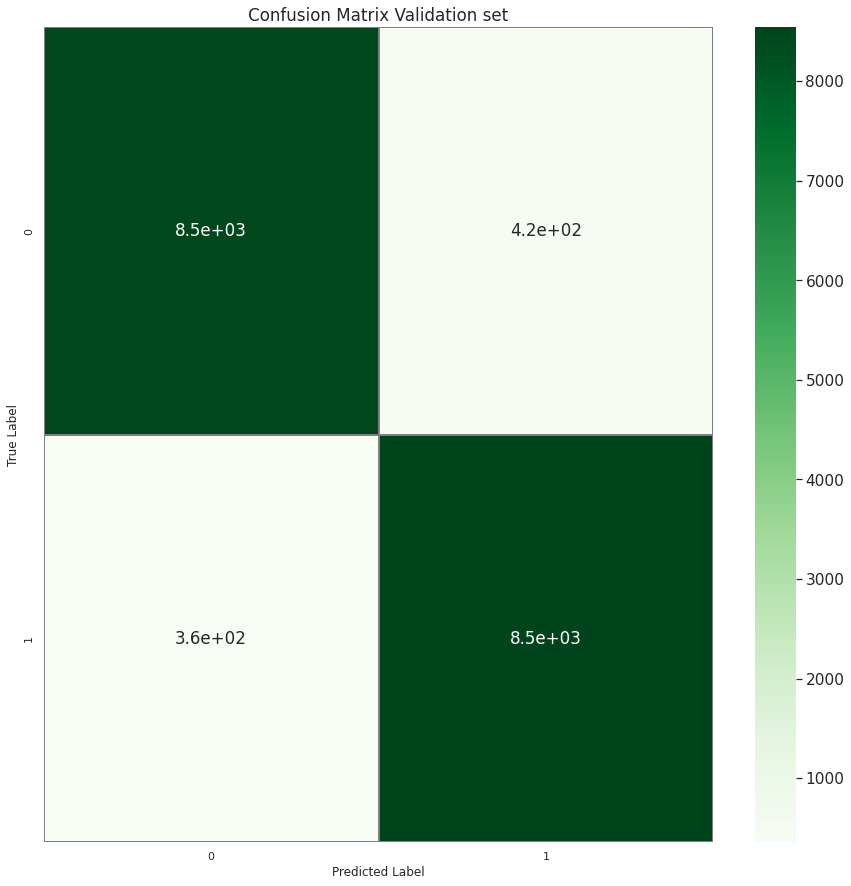

In [55]:
from sklearn.metrics import confusion_matrix

f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx = confusion_matrix(y_true, Y_val_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [56]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [57]:
metrics = []

precision, recall, fscore, _ = score(y_true, Y_val_pred, average='weighted')
accuracy = accuracy_score(y_true, Y_val_pred)
auc = roc_auc_score(y_true, Y_val_pred)
metrics.append(pd.Series({'precision':precision, 'recall':recall,
                          'fscore':fscore, 'accuracy':accuracy,
                          'auc':auc}, name='CNN model'))
    
metrics = pd.concat(metrics, axis=1)

In [58]:
metrics

,CNN model
precision,0.956208
recall,0.956180
fscore,0.956179
accuracy,0.956180
auc,0.956180


## Inference:


In [59]:
os.listdir('input/test')[:5]

['61f5792c2ae31fc1e0d5ee71b623aa6c435b5f31.tif',
 'bb6f68db3c4bad997f75299277e63d8e5ee382c7.tif',
 '4b61b957120f1fad85203e02ad73e5eef91cd414.tif',
 '5c45d1613c88c0a58a47bb35ed9a441351dd9832.tif',
 '1bc5b3da24dea364fbfd315c126a02091d2dac05.tif']

In [60]:
print('\n Amount of images in test dataset: ', len(os.listdir('input/test')))


 Amount of images in test dataset:  57458


In [61]:
# create test_dir
test_dir = 'test_set_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [63]:
# Transfer the test images into image_dir

test_list = os.listdir('input/test')

for image in test_list:
    fname = image
    # source path to image
    src = os.path.join('input/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [64]:
len(os.listdir('test_set_dir/test_images'))

57458

Once we copied all images to our 'test_set_dir' directory we have to gather them using the flow_from_directory function as before and use it as argument of the prediction function:

In [64]:
test_path = 'test_set_dir'
test_gen = datagen.flow_from_directory(test_path,
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       batch_size=1,
                                       class_mode='categorical',
                                       shuffle=False)

Found 57458 images belonging to 1 classes.


In [65]:
test_predictions = model_saved.predict(test_gen, steps=len(os.listdir('test_set_dir/test_images')), verbose=1)

2022-04-22 17:47:06.340958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


57458/57458 [==============================] - 138s 2ms/step


In [66]:
test_predictions

array([[2.3954285e-06],
       [4.0369436e-02],
       [9.4812147e-02],
       ...,
       [9.9998713e-01],
       [4.4308186e-01],
       [9.6124631e-01]], dtype=float32)

In [69]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
my_img=load_img('test/a.tif',target_size=(IMAGE_SIZE,IMAGE_SIZE))
my_img=img_to_array(my_img)
my_img=my_img.reshape((1,my_img.shape[0],my_img.shape[1],my_img.shape[2]))
pred=model_saved.predict(my_img,verbose=1)
pred

1/1 [==============================] - 0s 81ms/step


array([[1.]], dtype=float32)

In [70]:
from tensorflow.keras.applications import MobileNetV2

In [77]:
mob_netv2=MobileNetV2(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
for layer in mob_netv2.layers:
    layer.trainable=False
mob_net_model=Sequential()
mob_net_model.add(mob_netv2)
mob_net_model.add(Flatten())
mob_net_model.add(Dense(512,activation='relu'))
mob_net_model.add(BatchNormalization())
mob_net_model.add(Dropout(0.2))
mob_net_model.add(Dense(1,activation='sigmoid'))

mob_net_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [78]:
mob_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               5898752   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [79]:
mob_model_dir = 'Mobile_netv2.h5'
mob_checkpoint = ModelCheckpoint(mob_model_dir, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
history_mob_net = mob_net_model.fit(train_gen, validation_data=val_gen,
                              epochs=20, verbose=1,
                              callbacks=[lr_reduction, mob_checkpoint])

Epoch 1/20
5006/5007 [============================>.] - ETA: 0s - loss: 0.3828 - accuracy: 0.8285
Epoch 1: val_accuracy improved from -inf to 0.84365, saving model to Mobile_netv2.h5
5007/5007 [==============================] - 250s 50ms/step - loss: 0.3828 - accuracy: 0.8285 - val_loss: 0.3525 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 2/20
5007/5007 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8424
Epoch 2: val_accuracy improved from 0.84365 to 0.85270, saving model to Mobile_netv2.h5
5007/5007 [==============================] - 249s 50ms/step - loss: 0.3557 - accuracy: 0.8424 - val_loss: 0.3431 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 3/20
5007/5007 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.8479
Epoch 3: val_accuracy improved from 0.85270 to 0.85876, saving model to Mobile_netv2.h5
5007/5007 [==============================] - 252s 50ms/step - loss: 0.3464 - accuracy: 0.8479 - val_loss: 0.3256 - val_accuracy: 0.8588 - lr: 0.001

In [80]:
from tensorflow.keras.applications import ResNet50V2

In [81]:
res_netv2=ResNet50V2(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
for layer in res_netv2.layers:
    layer.trainable=False
res_net_model=Sequential()
res_net_model.add(res_netv2)
res_net_model.add(Flatten())
res_net_model.add(Dense(512,activation='relu'))
res_net_model.add(BatchNormalization())
res_net_model.add(Dropout(0.2))
res_net_model.add(Dense(1,activation='sigmoid'))

res_net_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

94683136/94668760 [==============================] - 9s 0us/step


In [82]:
res_net_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               9437696   
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                      

In [84]:
res_model_dir = 'ResNetv2.h5'
res_checkpoint = ModelCheckpoint(res_model_dir, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
history_res_net = res_net_model.fit(train_gen, validation_data=val_gen,
                              epochs=20, verbose=1,
                              callbacks=[lr_reduction, res_checkpoint])

Epoch 1/20
5006/5007 [============================>.] - ETA: 0s - loss: 0.3980 - accuracy: 0.8197
Epoch 1: val_accuracy improved from -inf to 0.83725, saving model to ResNetv2.h5
5007/5007 [==============================] - 248s 49ms/step - loss: 0.3980 - accuracy: 0.8197 - val_loss: 0.3671 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 2/20
5006/5007 [============================>.] - ETA: 0s - loss: 0.3788 - accuracy: 0.8309
Epoch 2: val_accuracy improved from 0.83725 to 0.84202, saving model to ResNetv2.h5
5007/5007 [==============================] - 247s 49ms/step - loss: 0.3787 - accuracy: 0.8309 - val_loss: 0.3597 - val_accuracy: 0.8420 - lr: 0.0010
Epoch 3/20
5007/5007 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8372
Epoch 3: val_accuracy improved from 0.84202 to 0.84433, saving model to ResNetv2.h5
5007/5007 [==============================] - 248s 50ms/step - loss: 0.3672 - accuracy: 0.8372 - val_loss: 0.3601 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 4/20

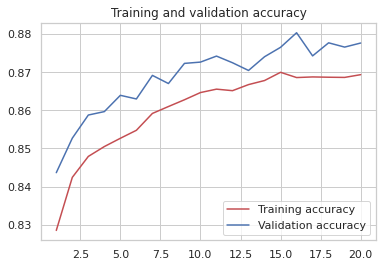

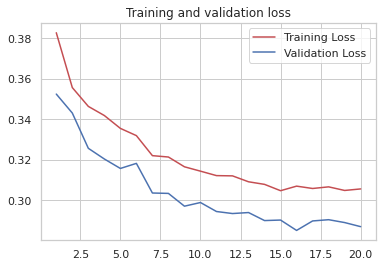

In [87]:
metrics_plot(history_mob_net)

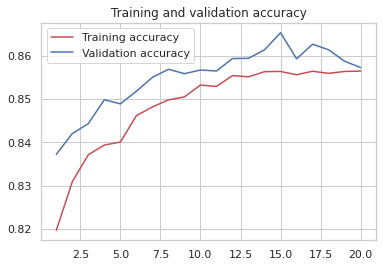

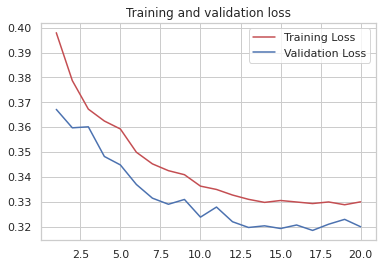

In [88]:
metrics_plot(history_res_net)

In [93]:
mob_net_df=pd.DataFrame(history_mob_net.history)
mob_net_df.to_csv("MobileNetV2stats.csv")
mob_net_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.382788,0.828514,0.352460,0.843652,0.001000
1,0.355671,0.842422,0.343081,0.852697,0.001000
2,0.346369,0.847915,0.325647,0.858764,0.001000
3,0.341853,0.850499,0.320360,0.859663,0.001000
4,0.335499,0.852672,0.315689,0.863933,0.001000
5,0.331919,0.854763,0.318198,0.862978,0.001000
6,0.322017,0.859182,0.303545,0.869157,0.000500
7,0.321339,0.860992,0.303350,0.867022,0.000500
8,0.316507,0.862765,0.297032,0.872303,0.000250
9,0.314351,0.864657,0.298840,0.872640,0.000250


In [94]:
res_net_df=pd.DataFrame(history_res_net.history)
res_net_df.to_csv("ResNet50V2stats.csv")
res_net_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.397970,0.819694,0.367139,0.837247,0.001000
1,0.378723,0.830924,0.359728,0.842022,0.001000
2,0.367247,0.837154,0.360130,0.844326,0.001000
3,0.362464,0.839388,0.348205,0.849831,0.001000
4,0.359257,0.840069,0.344803,0.848876,0.001000
5,0.349905,0.846167,0.336935,0.851798,0.000500
6,0.345220,0.848171,0.331432,0.855000,0.000500
7,0.342491,0.849794,0.328977,0.856854,0.000500
8,0.340871,0.850487,0.330906,0.855843,0.000500
9,0.336272,0.853221,0.323796,0.856685,0.000250
